In [1]:
import matplotlib.pyplot as plt

from ecodynelec.parameter import Parameter
from ecodynelec.pipelines import execute
from analysis_functions import compute_per_country
import pandas as pd
import matplotlib.pyplot as plt

my_config = Parameter()  # Initialize a configuration object
# Set base config
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT', 'CZ']
my_config.target = ['CH', 'FR']
my_config.data_cleaning = True
my_config.path.generation = "./test_data/downloads/generations/"
my_config.path.exchanges = "./test_data/downloads/exchanges/"

# Setup auto-downloading
my_config.server.useServer = False

## Change the starting date
my_config.start = '2021-01-01 00:00'
my_config.end = '2021-12-31 23:59'

In [220]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
impacts_dict, mixs_dict = execute(config=my_config, is_verbose=True)

Load auxiliary datasets...
Load generation data...
	Generation data.
Data loading: 11.32 sec.
Memory usage table: 196.13 MB
Autocomplete...               6/6)...
	Completed.                              
Extraction raw generation: 8.69 sec.             
	Extraction time: 20.42 sec.
	4/4 - Resample exchanges to H steps...
Get and reduce importation data...
	Cross-border flow data.
Data loading: 6.78 sec..
Memory usage table: 79.02 MB
Autocomplete...               ...
	Completed.                              
Extraction raw import: 1.74 sec.             
	Extraction time: 8.65 sec.
Resample exchanges to H steps...
Gather generation and importation...
Import of data: 29.4 sec
Importing information...
Tracking origin of electricity...
                     Biomass_AT  Fossil_Brown_coal/Lignite_AT   
2021-01-01 00:00:00       180.0                           0.0  \
2021-01-01 01:00:00       180.0                           0.0   
2021-01-01 02:00:00       180.0                           0.0   

In [222]:
de_mix = impacts_dict['FR']['Climate Change'].copy()
de_mix = de_mix.drop(de_mix.loc[:, [k.startswith('Mix') and not k.endswith('Other') for k in de_mix.columns]], axis=1)  # Keep only the production columns
biggest_cols = de_mix.mean().nlargest(10).index.tolist()

In [223]:
de_mix['sum'] = de_mix[biggest_cols].sum(axis=1)

<Axes: >

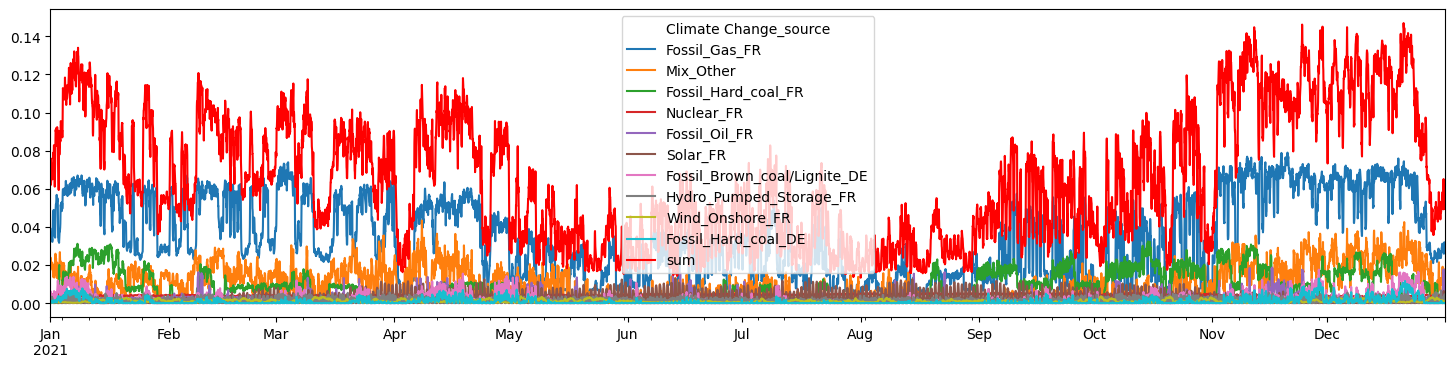

In [224]:
de_mix[biggest_cols].plot(figsize=(18,4), legend=True)
de_mix['sum'].plot(color='r', legend=True)

In [225]:
import numpy as np

tmp = mixs_dict['CH']
tmp = tmp.drop(tmp.loc[:, [k.startswith('Mix') and not k.endswith('Other') for k in tmp.columns]], axis=1)  # Keep only the production columns
ch_mix_per_country = compute_per_country(tmp)
ch_impacts_per_country = compute_per_country(impacts_dict['CH']['Climate Change'])

# Total impact for one kwh of the total DE mix
DE_impacts = impacts_dict['FR']['Climate Change'].sum(axis=1)

# DE impact for one kwh of the total CH mix
DE_impact_in_CH = ch_impacts_per_country['FR']

# share of DE electicity in CH mix (x kWh from DE / 1 kWh of CH mix)
# so for one kWh of CH mix, we have x kWh from DE
# so the DE impact for this 1 kWh in the CH mix is x * DE_impact
DE_share_in_CH = ch_mix_per_country['FR']
# extrapolated DE impact for one kwh of the total CH mix, using hourly gwp impact of DE
by_hand_DE_impact_in_CH = DE_impacts * DE_share_in_CH

# DE impacts average over the year
DE_impacts_avg = DE_impacts.mean()
# extrapolated DE impact for one kwh of the total CH mix, using average gwp impact of DE
by_hand_DE_impact_in_CH_avg = DE_impacts_avg * DE_share_in_CH

avg_DE_impact_in_CH = DE_impact_in_CH.mean()
DE_share_in_CH_2 = DE_share_in_CH.copy()
DE_share_in_CH_2[DE_share_in_CH_2 <= 0.01] = 0
avg_DE_impact_in_CH_1kwh = avg_DE_impact_in_CH / DE_share_in_CH_2
avg_DE_impact_in_CH_1kwh.replace([np.inf, -np.inf], 0, inplace=True)
avg2_DE_impact_in_CH_1kwh = avg_DE_impact_in_CH_1kwh.mean()

In [226]:
DE_impact_in_CH.sum() / DE_share_in_CH.sum()

0.04736863

In [227]:
DE_impacts_avg

0.06804508

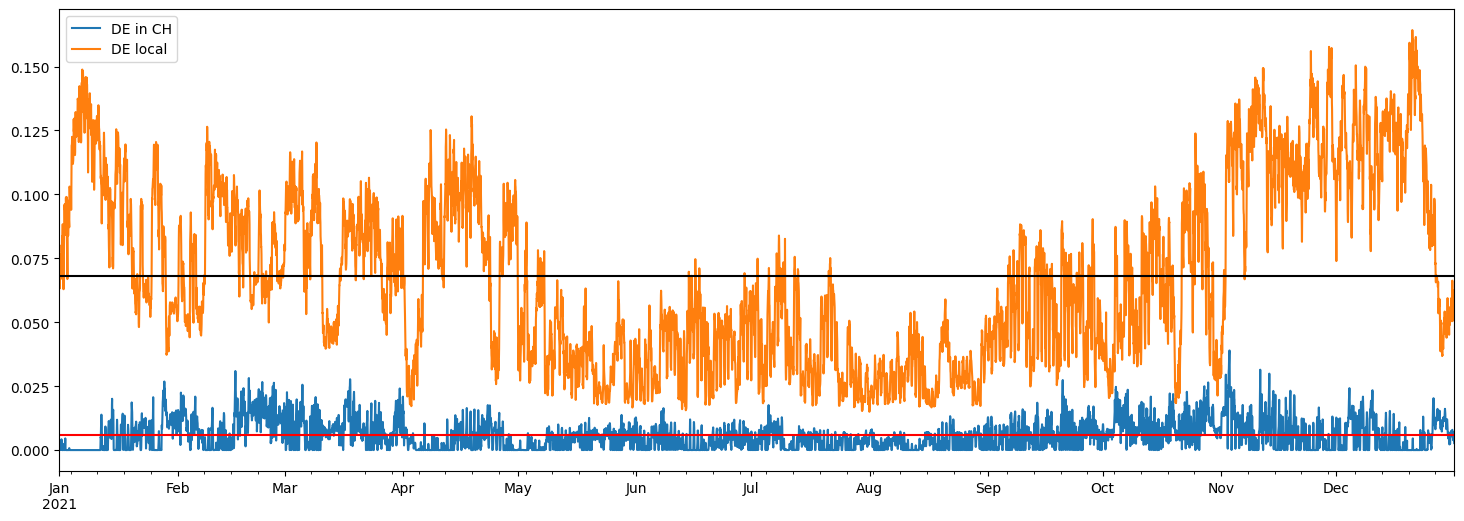

In [228]:
DE_impact_in_CH.plot(label="DE in CH", legend=True)
DE_impacts.plot(label="DE local", legend=True, figsize=(18,6))
plt.axhline(y=DE_impacts_avg, color='k')
plt.axhline(y=avg_DE_impact_in_CH, color='r')
plt.show()

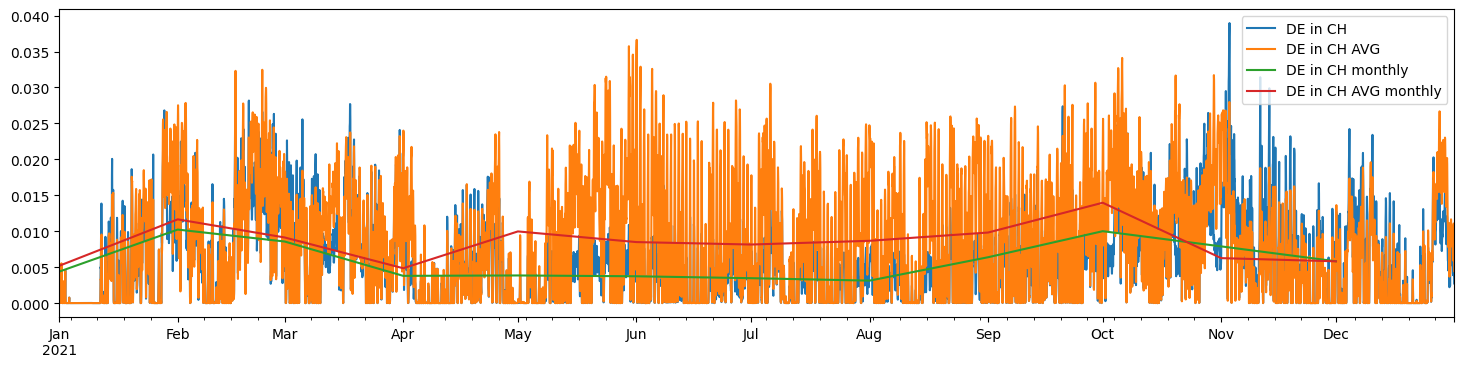

In [229]:
DE_impact_in_CH.plot(label="DE in CH", legend=True, figsize=(18,4))
by_hand_DE_impact_in_CH_avg.plot(label="DE in CH AVG", legend=True)
DE_impact_in_CH.resample('M').mean().plot(label="DE in CH monthly", legend=True)
by_hand_DE_impact_in_CH_avg.resample('M').mean().plot(label="DE in CH AVG monthly", legend=True)
plt.show()

<Axes: >

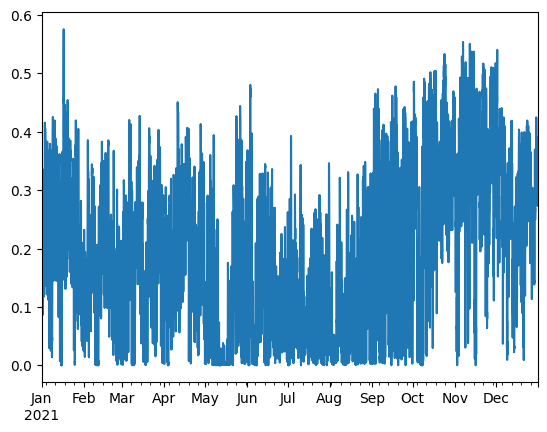

In [194]:
DE_share_in_CH.plot()

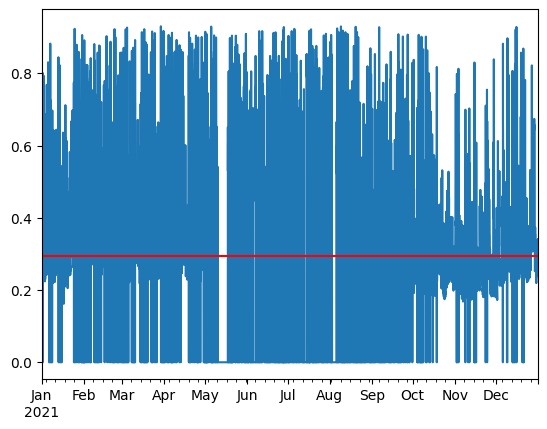

In [198]:
avg_DE_impact_in_CH_1kwh.plot()
plt.axhline(y=avg2_DE_impact_in_CH_1kwh, color='r')

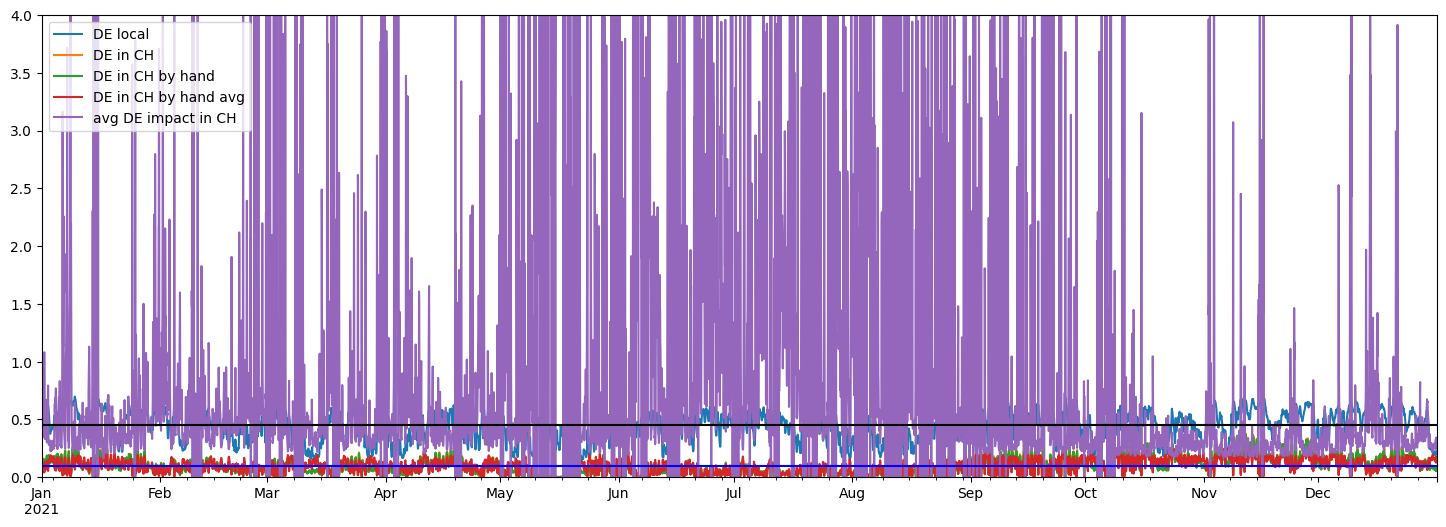

In [215]:
DE_impacts.plot(label="DE local", legend=True, figsize=(18,6))
DE_impact_in_CH.plot(label="DE in CH", legend=True)
by_hand_DE_impact_in_CH.plot(label="DE in CH by hand", legend=True)
by_hand_DE_impact_in_CH_avg.plot(label="DE in CH by hand avg", legend=True)
avg_DE_impact_in_CH_1kwh.plot(label="avg DE impact in CH", legend=True)
plt.axhline(y=DE_impacts_avg, color='k')
plt.axhline(y=avg_DE_impact_in_CH, color='b')
plt.ylim([0, 4])
plt.show()

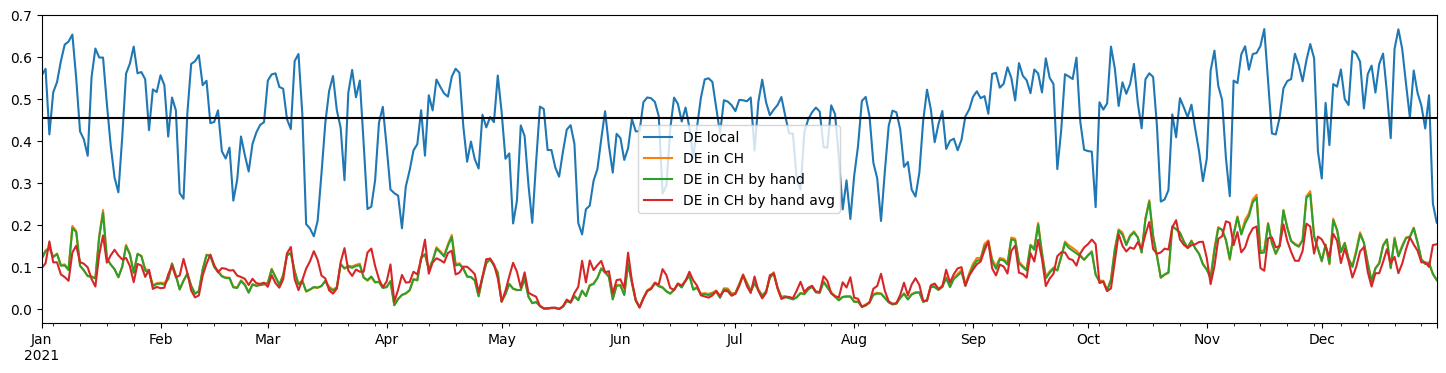

In [158]:
# same plot but daily
DE_impacts_daily = DE_impacts.resample('D').mean()
DE_impact_in_CH_daily = DE_impact_in_CH.resample('D').mean()
by_hand_DE_impact_in_CH_daily = by_hand_DE_impact_in_CH.resample('D').mean()
by_hand_DE_impact_in_CH_avg_daily = by_hand_DE_impact_in_CH_avg.resample('D').mean()
DE_impacts_avg_daily = DE_impacts_avg

DE_impacts_daily.plot(label="DE local", legend=True, figsize=(18,4))
DE_impact_in_CH_daily.plot(label="DE in CH", legend=True)
by_hand_DE_impact_in_CH_daily.plot(label="DE in CH by hand", legend=True)
by_hand_DE_impact_in_CH_avg_daily.plot(label="DE in CH by hand avg", legend=True)
plt.axhline(y=DE_impacts_avg_daily, color='k')

<Axes: >

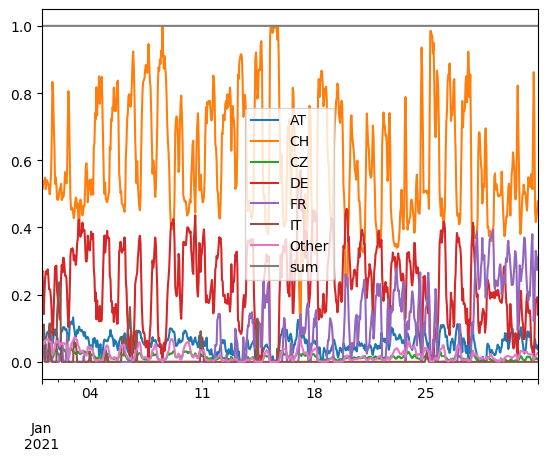

In [72]:
from etude_stat.analysis_functions import compute_per_country

mixs = mixs_dict['CH']
impacts = impacts_dict['CH']
mixs = mixs.drop(mixs.loc[:, [k.startswith('Mix') and not k.endswith('Other') for k in mixs.columns]], axis=1)  # Keep only the production columns
production_per_country = compute_per_country(mixs)
production_per_country['sum'] = production_per_country.sum(axis=1)  # Add total production
production_per_country.plot()

<Axes: >

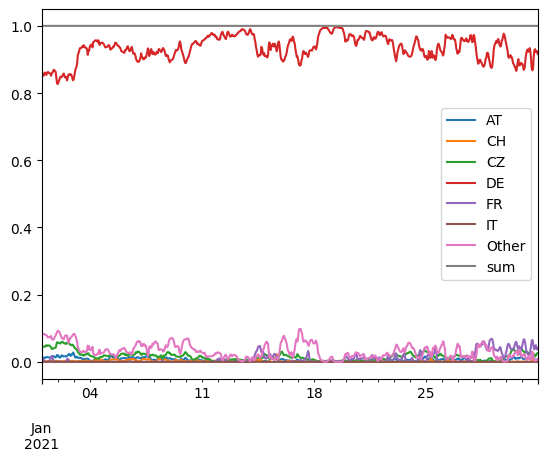

In [73]:
from etude_stat.analysis_functions import compute_per_country

mixs = mixs_dict['DE']
impacts = impacts_dict['DE']
mixs = mixs.drop(mixs.loc[:, [k.startswith('Mix') and not k.endswith('Other') for k in mixs.columns]], axis=1)  # Keep only the production columns
production_per_country = compute_per_country(mixs)
production_per_country['sum'] = production_per_country.sum(axis=1)  # Add total production
production_per_country.plot()

In [232]:
from ecodynelec.preprocessing.loading import import_data
from ecodynelec.tracking import reorder_info
from ecodynelec.preprocessing.auxiliary import load_rawEntso
import pandas as pd
import ecodynelec.preprocessing.auxiliary as aux

ctry = my_config.ctry

p = my_config
neighbours = aux.load_useful_countries(path_neighbour=p.path.neighbours, ctry=p.ctry)
raw_prodExch = import_data(ctry=p.ctry, start=p.start, end=p.end, freq=p.freq, involved_countries=neighbours, prod_gap=None, sg_data=None,
                           path_gen=p.path.generation, path_imp=p.path.exchanges,
                           savedir=p.path.savedir, net_exchange=p.net_exchanges,
                           residual_global=p.residual_global, correct_imp=p.sg_imports,
                           clean_data=p.data_cleaning, is_verbose=True)

df = load_rawEntso(mix_data=raw_prodExch, freq=my_config.freq)
ctry, ctry_mix, prod_means, all_sources = reorder_info(data=df)

power = {}
energys = {}
for t in range(df.shape[0]):
    energy = pd.DataFrame(data=df.iloc[t].values.reshape(( len(ctry) , len(prod_means) )),
                           columns=prod_means, index=ctry, dtype='float32')
    energys[t] = energy
    power[t] = energy.sum(axis=1)

Load generation data...
	Generation data.
Data loading: 14.6 sec..
Memory usage table: 196.13 MB
Autocomplete...               6/6)...
	Completed.                              
Extraction raw generation: 8.78 sec.             
	Extraction time: 23.81 sec.
	4/4 - Resample exchanges to H steps...
Get and reduce importation data...
	Cross-border flow data.
Data loading: 7.84 sec..
Memory usage table: 79.02 MB
Autocomplete...               ...
	Completed.                              
Extraction raw import: 2.92 sec.             
	Extraction time: 10.93 sec.
Resample exchanges to H steps...
Gather generation and importation...
Import of data: 36.6 sec


In [27]:
print(energys[0].loc['CH'])

Biomass                            0.000000e+00
Fossil_Brown_coal/Lignite          0.000000e+00
Fossil_Coal-derived_gas            0.000000e+00
Fossil_Gas                         0.000000e+00
Fossil_Hard_coal                   0.000000e+00
Fossil_Oil                         0.000000e+00
Fossil_Oil_shale                   0.000000e+00
Fossil_Peat                        0.000000e+00
Geothermal                         0.000000e+00
Hydro_Pumped_Storage               6.379195e+05
Hydro_Run-of-river_and_poundage    1.397105e+05
Hydro_Water_Reservoir              1.276275e+06
Marine                             0.000000e+00
Nuclear                            2.164081e+06
Other_fossil                       0.000000e+00
Other_renewable                    0.000000e+00
Solar                              3.564388e+04
Waste                              0.000000e+00
Wind_Offshore                      0.000000e+00
Wind_Onshore                       1.547693e+04
Mix_AT                             6.106

In [ ]:
# DE share


In [233]:
power = pd.DataFrame(power).T

In [237]:
power.index = df.index

<Axes: >

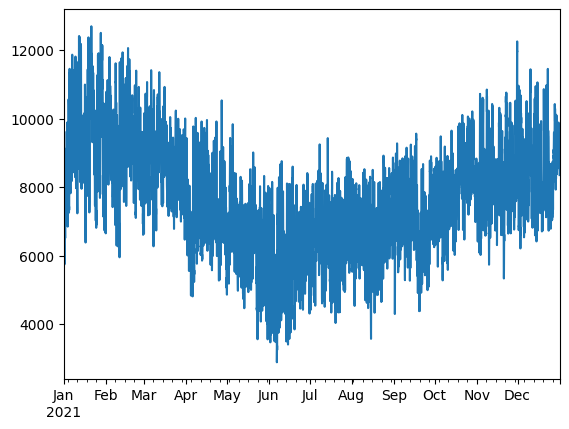

In [238]:
power['CH'].plot()

In [42]:
print(power)

          AT         CH         CZ          DE          FR          IT
0  7325018.0  7031109.5  8797179.0  49445780.0  57810660.0  25237198.0


In [24]:
power

,AT,CH,CZ,DE,FR,IT
0,8331.181641,6805.379883,9501.280273,47136.371094,66644.281250,21109.480469
1,8172.047363,6854.729980,9760.000000,46450.480469,65549.023438,19966.519531
2,7930.928711,6372.910156,9990.540039,46137.390625,63621.089844,19254.640625
3,7966.787598,6370.359863,10225.590820,45550.718750,62945.015625,19152.050781
4,8163.495117,6344.590332,10244.850586,45477.929688,62750.820312,19193.250000
5,8400.338867,6331.950195,10364.020508,46013.148438,63555.917969,19602.830078
6,8571.044922,6895.909668,10483.230469,46707.351562,65149.988281,20800.740234
7,9003.652344,6549.549805,10338.830078,46865.351562,66004.820312,21389.009766
8,9412.046875,6428.830078,10724.240234,48190.636719,67800.968750,22635.039062
9,9652.676758,6544.329590,10712.459961,49750.894531,69353.507812,23694.570312


In [25]:
sm = power.sum()

In [27]:
print(sm)

AT    2.175530e+05
CH    1.661435e+05
CZ    2.495139e+05
DE    1.192695e+06
FR    1.632572e+06
IT    5.699249e+05
dtype: float32
